# Analyse
Im Folgenden werden die Analysen auf dem Vorbereiteten Umfragedatensatz durchgeführt. Die nummerierten Überschriften 4.x sind dabei inhaltlich identisch zu den gleichnamigen in der Arbeit.

## 4.1 Voranalysen
Um die Effekte der Variablen zu prüfen wurden diese in kategoriale (Gender, Nationalität, Bildungsgrad) und kontinuierliche Variablen (Durchführungsdauer, Alter) unterteilt und jeweils unterschiedlich analysiert.

In [115]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

df = pd.read_csv('survey_data/survey_cleaned.csv')
df_reviews = pd.read_csv('review_samples/sample_df.csv')
df_group1 = df[df['group'] == 1].copy()
df_group2 = df[df['group'] == 2].copy()
df_group3 = df[df['group'] == 3].copy()

### 4.1.1 Kategoriale Variablen (Gender, Nationalität, Bildungsgrad)
Um die Unterschiede zwischen den Gruppen in Bezug auf verschiedene Zielvariablen zu untersuchen, wurde eine einfaktorielle Varianzanalyse (ANOVA) durchgeführt. Die Zielvariablen, die analysiert wurden, sind: Solo-Performance, Team-Performance, Häufigkeit der Änderung der Antwort mit der KI (wenn KI richtig/falsch lag) sowie die Häufigkeit, dass die Antwort überhaupt geändert wurde. Diese wurden dabei in Bezug auf die Gruppierungsvariablen Gender, Nationalität und Bildungsgrad untersucht.

Bei der Untersuchung der Unterschiede in den Zielvariablen in Bezug auf die Genderzugehörigkeit ergab die ANOVA keine signifikanten Unterschiede zwischen den Gruppen. Der niedrigste p-Wert der lag dabei bei 0.146 für die Zielvariable Solo-Performance. Die anderen Zielvariablen hatten p-Werte zwischen 0.299 und 0.708. Diese Ergebnisse (Tabelle 6) deuten darauf hin, dass das Geschlecht keinen signifikanten Einfluss auf die betrachteten Zielvariablen hat.

Bei der Untersuchung der Unterschiede in den Zielvariablen in Bezug auf die Nationalität zeigten beide Performance-Variablen signifikante Unterschiede zwischen den Nationalitätsgruppen. Insbesondere für Solo-Performance war der F-Wert 2.573 (p = 0.004) und für Team-Performance betrug der F-Wert 2.110 (p = 0.019), was auf signifikante Unterschiede zwischen den Gruppen hinweist. Die anderen Zielvariablen zeigten keine signifikanten Unterschiede zwischen den Nationalitätsgruppen. (siehe Tabelle 7)

Bei der Untersuchung der Unterschiede in den Zielvariablen in Bezug auf den Bildungsstand ergab die ANOVA keine signifikanten Unterschiede zwischen den Bildungsgruppen. Wie der Tabelle 8 zu entnehmen ist, liegen die p-Werte für alle betrachteten Zielvariablen deutlich über 0.05, was darauf hindeutet, dass der Bildungsstand keinen signifikanten Einfluss auf die betrachteten Zielvariablen hat.

Zusätzlich zur ANOVA wurde versucht, die Voraussetzungen der Testmethode durch den Shapiro-Wilk-Test (Überprüfung der Normalverteilung) und den Levene-Test (Überprüfung der Homogenität der Varianzen) zu überprüfen. Es ist jedoch wichtig zu beachten, dass diese Tests in einigen Fällen nicht durchführbar waren, da bestimmte Nationalitäten, Geschlechter und Bildungsgrade in den Daten weniger als dreimal vorkamen. Dieser Mangel an Datenpunkten in einigen Kategorien verhinderte eine zuverlässige Überprüfung der ANOVA-Voraussetzungen für diese spezifischen Gruppen.

In [116]:
target_variables = ['v_solo_correct_sum', 'v_ai_correct_sum', 'v_followed_correct_ai_sum', 
                    'v_followed_wrong_ai_sum', 'v_changed_sum']
grouping_variables = ['v_gender', 'Nationality', 'v_education']

print("ANOVA Geschlecht und Nationalität:")
results = {
    group: {"target": [], "F-value": [], "p-value": []}
    for group in grouping_variables
}

for target in target_variables:
    for group in grouping_variables:
        f_val, p_val = stats.f_oneway(*[df[target][df[group] == g] for g in df[group].unique()])
        results[group]["target"].append(target)
        results[group]["F-value"].append(f_val)
        results[group]["p-value"].append(p_val)

for group, data in results.items():
    df_result = pd.DataFrame(data)
    print(f"ANOVA für {group}:\n", df_result, "\n")


ANOVA Geschlecht und Nationalität:
ANOVA für v_gender:
                       target   F-value   p-value
0         v_solo_correct_sum  0.898446  0.411427
1           v_ai_correct_sum  1.975766  0.145622
2  v_followed_correct_ai_sum  1.224900  0.299447
3    v_followed_wrong_ai_sum  0.347502  0.707553
4              v_changed_sum  0.637967  0.531135 

ANOVA für Nationality:
                       target   F-value   p-value
0         v_solo_correct_sum  2.572912  0.004003
1           v_ai_correct_sum  2.110164  0.018704
2  v_followed_correct_ai_sum  1.568105  0.104705
3    v_followed_wrong_ai_sum  1.297877  0.226945
4              v_changed_sum  1.494200  0.130418 

ANOVA für v_education:
                       target   F-value   p-value
0         v_solo_correct_sum  0.270711  0.846330
1           v_ai_correct_sum  0.495467  0.686508
2  v_followed_correct_ai_sum  0.550590  0.649287
3    v_followed_wrong_ai_sum  1.404574  0.247994
4              v_changed_sum  1.582964  0.200440 



Trotz der nicht gegebenen Voraussetzungen für die ANOVA, konnte diese einen Hinweis auf einen Einfluss der Nationalität auf die Performance der Probanden liefern. Um dies weiter zu untersuchen, wurde die Solo-Performance in Abhängigkeit der Nationalität betrachtet. Bei dem Vergleich der durchschnittlichen Solo-Performance der verschiedenen Nationalitäten wird deutlich, dass Südafrika deutlich unter den anderen Nationalitäten liegt. Mit durchschnittlich 15.75 richtig eingeschätzten Reviews lag der Wert deutlich niedriger als die Werte der anderen Nationen mit 10 oder mehr Probanden. So lag der Wert für Polen bei 19.0, für Portugal bei ebenfalls 19.0 und für Mexiko bei 17.5. Lediglich die Ukraine hatte einen schlechteren Durchschnitt von 12.0. Allerdings ist die Aussagekraft hier sehr gering, da nur ein Proband dieser Nationalität angehörte. In der folgenden Abbildung 3 wurden die Verteilungen für alle Nationalitäten mit n > 1 dargestellt. Im Vergleich mit den anderen Nationen wird die niedrigere Solo-Performance Südafrikas besonders deutlich.

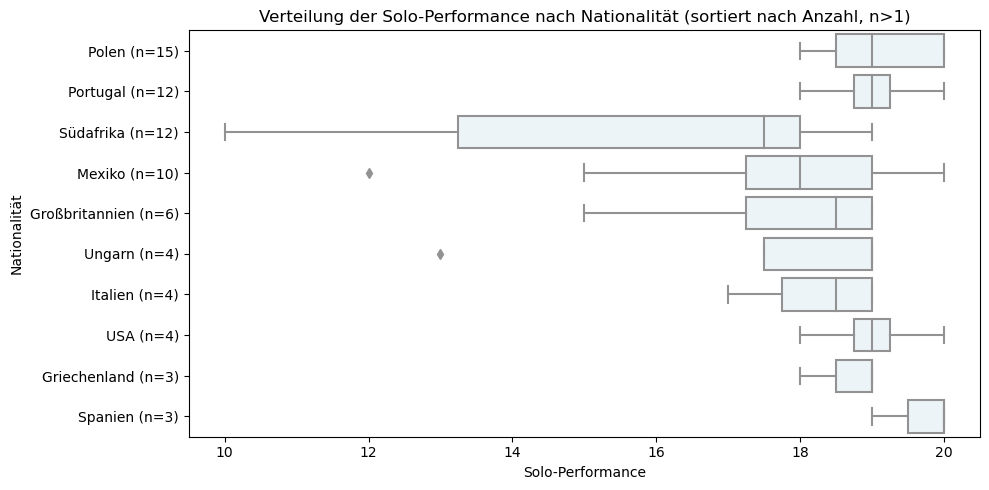

In [117]:
target_vars = ['v_solo_correct_sum', 'v_ai_correct_sum']
group_var = 'Nationality'
summary_stats = []
for target in target_vars:
    for group in df[group_var].unique():
        group_data = df[df[group_var] == group][target].dropna()
        
        if not group_data.empty:
            mean_val = group_data.mean()
            median_val = group_data.median()
            sample_size = len(group_data)
            summary_stats.append({
                'Target Variable': target,
                'Grouping Variable': group_var,
                'Group': group,
                'Mean': mean_val,
                'Median': median_val,
                'Sample Size': sample_size
            })
summary_stats_df = pd.DataFrame(summary_stats)

df_filtered = df[df['Nationality'] != 'DATA_EXPIRED']
summary_stats_df_filtered = df_filtered.groupby('Nationality').describe()['v_solo_correct_sum']
sorted_groups_by_samplesize = summary_stats_df_filtered.sort_values(by='count', ascending=False).index

translations = {
    'Belgium': 'Belgien',
    'Canada': 'Kanada',
    'Chile': 'Chile',
    'Finland': 'Finnland',
    'Greece': 'Griechenland',
    'Hungary': 'Ungarn',
    'Italy': 'Italien',
    'Mexico': 'Mexiko',
    'Poland': 'Polen',
    'Portugal': 'Portugal',
    'Slovenia': 'Slowenien',
    'South Africa': 'Südafrika',
    'Spain': 'Spanien',
    'Ukraine': 'Ukraine',
    'United Kingdom': 'Großbritannien',
    'United States': 'USA'
}

sorted_groups_by_samplesize = summary_stats_df_filtered[summary_stats_df_filtered['count'] > 1].sort_values(by='count', ascending=False).index
labels_with_samplesize_german = [f"{translations[group]} (n={int(summary_stats_df_filtered.loc[group, 'count'])})"
                                for group in sorted_groups_by_samplesize if group in translations]
locs_german = range(len(labels_with_samplesize_german))

plt.figure(figsize=(10, 5))
sns.boxplot(y='Nationality', x='v_solo_correct_sum', data=df_filtered, 
            order=[group for group in sorted_groups_by_samplesize if group in translations], 
            color='#ebf4fa')
plt.yticks(ticks=locs_german, labels=labels_with_samplesize_german)
plt.ylabel('Nationalität')
plt.xlabel('Solo-Performance')
plt.title('Verteilung der Solo-Performance nach Nationalität (sortiert nach Anzahl, n>1)')
plt.tight_layout()
plt.savefig('figures/boxplot_nationality.png', dpi=1000)
plt.show()

Ein T-Test, der die durchschnittliche Solo-Performance Südafrika, mit der der anderen Nationen vergleicht, wurde signifikant mit einem F-Wert von 1.58 (p = 0.017). Das Gleiche gilt für einen Test auf den Unterschied der Team-Performance (F = 1.58; p = 0.03).
Die Probanden aus Südafrika waren dabei annähernd gleich verteilt auf die drei verschiedenen Versuchsgruppen (Gruppe 1: 3; Gruppe 2: 5; Gruppe 3: 4).

In [118]:
south_africa_data = df[df['Nationality'] == 'South Africa']
other_nationalities_data = df[df['Nationality'] != 'South Africa']
for target in ['v_solo_correct_sum', 'v_ai_correct_sum']:
    t_val, p_val = stats.ttest_ind(south_africa_data[target], other_nationalities_data[target], equal_var=False)
    print(f"{target}: F-value: {f_val}, p-value: {p_val}")

south_africa_counts = df[df['Nationality'] == 'South Africa'].groupby('group').size()
south_africa_counts

v_solo_correct_sum: F-value: 1.5829641921071287, p-value: 0.017320772259547045
v_ai_correct_sum: F-value: 1.5829641921071287, p-value: 0.02964814104981685


group
1    3
2    5
3    4
dtype: int64

### 4.1.2 Kontinuierliche Variablen
Die Effekte der beiden kontinuierlichen Variablen „Durchführungsdauer“ und „Alter“ auf die Solo-Performance der Probanden wurden mithilfe von linearen Regressionen untersucht. Die Variable „Durchführungsdauer“ ist dabei die Zeit, die ein Proband für das Bearbeiten der gesamten Studie gebraucht hat.

Die für „Durchführungsdauer“ durchgeführte lineare Regression in Abbildung 4 zeigt einen schwachen Zusammenhang von „Durchführungsdauer“ und Solo-Performance. Dies wird zusätzlich durch einen Korrelationskoeffizient von R2=0.0286 unterstrichen. Mit einem T-Wert von 1.497 und einem p-Wert von 0.1387 ist der Effekt der „Durchführungsdauer“ auf die Solo-Performance nicht signifikant.

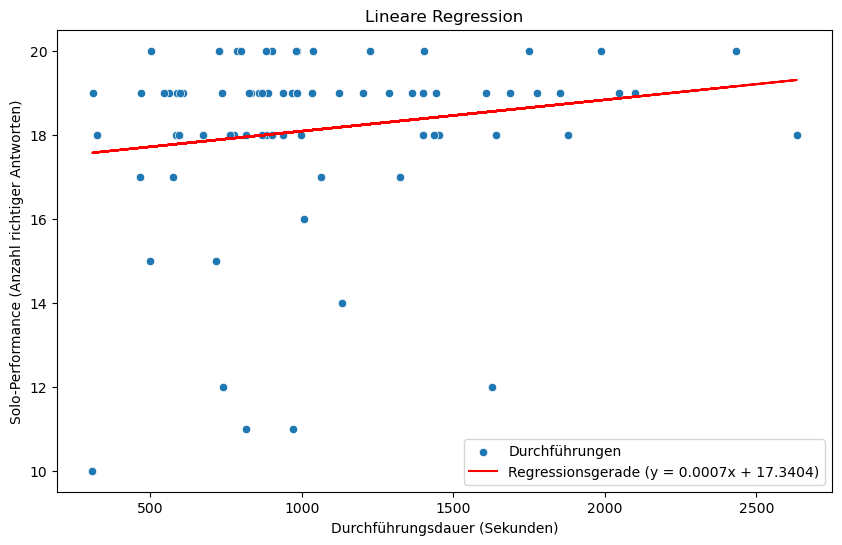

t-Wert: 1.4965
p-Wert: 0.1387
r2-Wert: 0.0286


In [119]:
filtered_data = df[(df['duration'] >= 0) & (df['duration'] <= 3000)]
duration_filtered = filtered_data['duration'].values.reshape(-1, 1)
performance_filtered = filtered_data['v_solo_correct_sum'].values.reshape(-1, 1)

regression_model = LinearRegression()
regression_model.fit(duration_filtered, performance_filtered)

performance_pred = regression_model.predict(duration_filtered)

slope = regression_model.coef_[0][0]
intercept = regression_model.intercept_[0]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_data['duration'], y=filtered_data['v_solo_correct_sum'], label='Durchführungen')
plt.plot(duration_filtered, performance_pred, color='red', label=f'Regressionsgerade (y = {slope:.4f}x + {intercept:.4f})')
plt.xlabel('Durchführungsdauer (Sekunden)')
plt.ylabel('Solo-Performance (Anzahl richtiger Antworten)')
plt.title('Lineare Regression')
plt.legend()
plt.savefig("figures/linreg_duration.png", dpi=3000)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['duration'], filtered_data['v_solo_correct_sum'])
t_statistic = slope / std_err

print(f"t-Wert: {t_statistic:.4f}")
print(f"p-Wert: {p_value:.4f}")
print(f"r2-Wert: {r_value**2:.4f}")

Zusätzlich wurden Pearson-Korrelationstests durchgeführt, um den Einfluss der „Durchführungsdauer“ auf verschiedene Performance- und Wechselverhaltens-Variablen zu prüfen. Hierbei konnten keine signifikanten Effekte festgestellt werden (siehe Tabelle 9).

In [120]:
def calculate_pearson(column):
    relevant_columns = ['v_solo_correct_sum', 'v_ai_correct_sum', 'v_followed_correct_ai_sum', 'v_followed_wrong_ai_sum',  'v_changed_sum']
    correlation_results = {}

    filtered_data = df[(df['duration'] >= 0) & (df['duration'] <= 3000)]

    for rel_col in relevant_columns:
        correlation, p_value = stats.pearsonr(filtered_data[rel_col], filtered_data[column])
        key = f"{rel_col}"
        correlation_results[key] = {'R2': correlation**2, 'p-Value': p_value}

    return pd.DataFrame(correlation_results).T


calculate_pearson('duration')

,R2,p-Value
v_solo_correct_sum,0.028622,0.138675
v_ai_correct_sum,0.016649,0.260212
v_followed_correct_ai_sum,0.019705,0.220267
v_followed_wrong_ai_sum,0.006877,0.470422
v_changed_sum,0.005294,0.526676


Die lineare Regression von „Alter“ auf Solo-Performance ergibt eine Regressionslinie mit einer geringen Steigung (siehe Abbildung 5). Der Korrelationskoeffizient R2 ist mit 0.001 sehr gering. Auch der T-Wert von 0.246 und der p-Wert von 0.806 ergeben keinen signifikanten Effekt des Alters der Probanden auf die Solo-Performance.

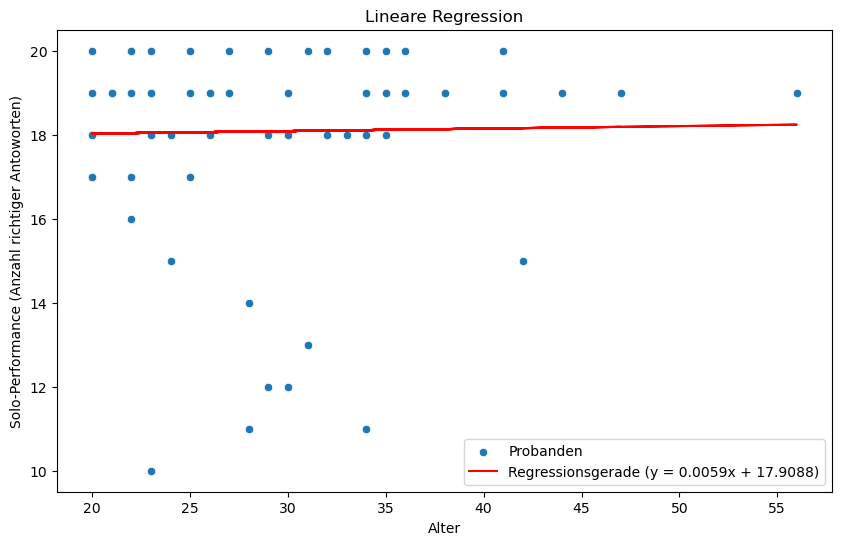

t-Wert: 0.2464
p-Wert: 0.8060
r2-Wert: 0.0008


In [121]:
age_filtered = df['v_age'].values.reshape(-1, 1)
performance_filtered = df['v_solo_correct_sum'].values.reshape(-1, 1)

regression_model = LinearRegression()
regression_model.fit(age_filtered, performance_filtered)

performance_pred = regression_model.predict(age_filtered)

slope = regression_model.coef_[0][0]
intercept = regression_model.intercept_[0]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['v_age'], y=df['v_solo_correct_sum'], label='Probanden')
plt.plot(age_filtered, performance_pred, color='red', label=f'Regressionsgerade (y = {slope:.4f}x + {intercept:.4f})')
plt.xlabel('Alter')
plt.ylabel('Solo-Performance (Anzahl richtiger Antoworten)')
plt.title('Lineare Regression')
plt.legend()
plt.savefig("figures/linreg_age.png", dpi=3000)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['v_age'], filtered_data['v_solo_correct_sum'])
t_statistic = slope / std_err

print(f"t-Wert: {t_statistic:.4f}")
print(f"p-Wert: {p_value:.4f}")
print(f"r2-Wert: {r_value**2:.4f}")

Die Pearson-Korrelationstests für den Einfluss des „Alters“ auf verschiedene Performance- und Wechselverhaltens-Variablen ergab ebenfalls keine signifikanten Effekte (siehe Tabelle 10).

In [122]:
calculate_pearson('v_age')

,R2,p-Value
v_solo_correct_sum,0.000798,0.806031
v_ai_correct_sum,0.000817,0.803782
v_followed_correct_ai_sum,0.006060,0.498129
v_followed_wrong_ai_sum,0.010958,0.361721
v_changed_sum,0.009423,0.397843


## 4.2 Hauptanalysen
Die Analyse der Daten hinsichtlich der ursprünglichen Fragestellung erfolgte in drei Schritten. In jedem Schritt wurden die Daten aus der Umfrage anders formatiert, um jeweils einen anderen Blickwinkel darauf zu erhalten. Zunächst wurden die Daten nach Gruppenzugehörigkeit untersucht, um Unterschiede in den durchschnittlichen Werten zwischen den Gruppen festzustellen. Anschließend wurden die Daten so aufbereitet, dass jedes Bearbeiten eines Reviews einen Datenpunkt darstellt. Diese 1600 Tasks  wurden ausgewertet, um zu untersuchen, wie sich die Probanden in verschiedenen Situationen verhalten – beispielsweise, wenn sie in ihrer Einschätzung erst falsch lagen, die KI-Einschätzung aber richtig war. Zuletzt wurden die Daten nach Reviews unterteilt, um Unterschiede zwischen den 20 verschiedenen Reviews festzustellen. Insbesondere wurde dabei auch darauf geschaut, wie sich die Schwierigkeit der Reviews auf das Verhalten der Probanden auswirkt.

### 4.2.1 Auswertung nach Gruppen
Um einen Überblick zu erhalten, wurden die durchschnittlichen Häufigkeiten von folgenden Ereignissen pro Gruppe berechnet: Proband gibt ohne Hilfe die richtige Antwort (Solo-Performance), Proband gibt nach Anzeige der KI-Ergebnisse die richtige Antwort (Team-Performance), Proband ändert die Antwort nach Anzeige der KI-Ergebnisse (Antwort geändert), Proband gleicht seine Antwort der KI an (KI gefolgt) und Proband gibt final die gleiche Antwort wie die KI (Gleiche Antwort wie KI). Die Übersicht über diese Werte (siehe Tabelle 11) zeigt nur geringe Unterschiede zwischen den Gruppen. Auffällig ist die etwas schlechtere Solo-Performance von Gruppe 3 gegenüber den anderen Gruppen sowie das allgemein niedrige Niveau der Werte für das Wechselverhalten (Antwort geändert, KI gefolgt). Ausschlaggebend dafür ist der Wert „Antwort geändert“, der aufzeigt, dass die Probanden im Schnitt weniger als einmal die ursprünglich gegebene Antwort revidierten, nachdem ihnen die KI-Ergebnisse angezeigt wurden.

In [123]:
group_dfs = [df_group1, df_group2, df_group3, df]
data = {
    'Solo': [],
    'AI': [],
    'Changed': [],
    'Followed AI': [],
    'Followed AI (Correct)': [],
    'Followed AI (Wrong)': [],
    'Same as AI': []
}

for group_df in group_dfs:
    data['Solo'].append(group_df['v_solo_correct_sum'].mean())
    data['AI'].append(group_df['v_ai_correct_sum'].mean())
    data['Changed'].append(group_df['v_changed_sum'].mean())
    data['Followed AI'].append(group_df['v_followed_ai_sum'].mean())
    data['Followed AI (Correct)'].append(group_df['v_followed_correct_ai_sum'].mean())
    data['Followed AI (Wrong)'].append(group_df['v_followed_wrong_ai_sum'].mean())
    data['Same as AI'].append(group_df['v_same_as_ai_sum'].mean())

group_differences = pd.DataFrame(data, index=["Gruppe 1", "Gruppe 2", "Gruppe 3", "insgesamt"])

group_differences.T



,Gruppe 1,Gruppe 2,Gruppe 3,insgesamt
Solo,18.214286,18.347826,17.724138,18.0750
AI,18.035714,18.434783,17.793103,18.0625
Changed,0.678571,0.434783,0.896552,0.6875
Followed AI,0.642857,0.434783,0.758621,0.6250
Followed AI (Correct),0.250000,0.260870,0.482759,0.3375
Followed AI (Wrong),0.392857,0.173913,0.275862,0.2875
Same as AI,17.321429,17.956522,17.413793,17.5375


Diese Werte wurden anschließend mithilfe einer ANOVA getestet. Dabei konnten keine signifikanten Unterschiede zwischen den Versuchsgruppen festgestellt werden (siehe Tabelle 12).

In [124]:
variables_to_analyze = [
    'v_solo_correct_sum',
    'v_ai_correct_sum',
    'v_changed_sum',
    'v_followed_ai_sum',
    'v_followed_correct_ai_sum',
    'v_followed_wrong_ai_sum',
    'v_same_as_ai_sum'
]

rows = []
for var in variables_to_analyze:
    groups = [df[var][df['group'] == group] for group in df['group'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    row = pd.DataFrame([{
        'Variable': var,
        'F-Statistik': f_stat,
        'p-Wert': p_value
    }])
    rows.append(row)

group_differences_anova = pd.concat(rows, ignore_index=True)

group_differences_anova

,Variable,F-Statistik,p-Wert
0,v_solo_correct_sum,0.584458,0.559861
1,v_ai_correct_sum,0.701941,0.498766
2,v_changed_sum,0.875336,0.420827
3,v_followed_ai_sum,0.516002,0.598951
4,v_followed_correct_ai_sum,0.650167,0.524800
5,v_followed_wrong_ai_sum,1.190425,0.309625
6,v_same_as_ai_sum,1.184967,0.311269


Die Normalverteilung der Residuen und die Homogenität der Varianzen als Voraussetzungen der ANOVA wurden getestet. Der Shapiro-Wilk Test ergab, dass die Normalverteilung nicht gegeben ist. Die p-Werte der Tests für die verschiedenen Variablen lagen alle deutlich unter dem Wert 0.01. Die Homogenität der Varianzen konnte mithilfe eines Levene-Tests jedoch nachgewiesen werden. Hier lagen die p-Werte der Variablen alle zwischen 0.3 und 0.6.

In [125]:
shapiro_results = {}
levene_results = {}
for var in variables_to_analyze:
    _, p_value = stats.shapiro(df[var])
    shapiro_results[var] = p_value
for var in variables_to_analyze:
    groups = [df[var][df['group'] == group] for group in df['group'].unique()]
    _, p_value = stats.levene(*groups)
    levene_results[var] = p_value
shapiro_df = pd.DataFrame.from_dict(shapiro_results, orient='index', columns=['p-Wert (Shapiro-Wilk)'])
levene_df = pd.DataFrame.from_dict(levene_results, orient='index', columns=['p-Wert (Levene)'])
print("Shapiro-Wilk Test Results:")
print(shapiro_df)
print("\nLevene Test Results:")
print(levene_df)

Shapiro-Wilk Test Results:
                           p-Wert (Shapiro-Wilk)
v_solo_correct_sum                  1.429118e-11
v_ai_correct_sum                    9.869860e-11
v_changed_sum                       3.564424e-13
v_followed_ai_sum                   3.640808e-13
v_followed_correct_ai_sum           1.224486e-15
v_followed_wrong_ai_sum             9.538281e-14
v_same_as_ai_sum                    3.680830e-10

Levene Test Results:
                           p-Wert (Levene)
v_solo_correct_sum                0.509511
v_ai_correct_sum                  0.489849
v_changed_sum                     0.420827
v_followed_ai_sum                 0.598951
v_followed_correct_ai_sum         0.524800
v_followed_wrong_ai_sum           0.309625
v_same_as_ai_sum                  0.379021


Aufgrund der nicht erfüllten Normalverteilung der Residuen sind die Voraussetzung der ANOVA nicht erfüllt. Daher wurde alternativ ein Kruskal-Willis Test durchgeführt. Auch dieser konnte jedoch keine signifikanten Unterschiede zwischen den Gruppen feststellen (siehe Tabelle 13).

In [126]:
rows = []

for var in variables_to_analyze:
    groups = [df[var][df['group'] == group] for group in df['group'].unique()]
    h_stat, p_value = stats.kruskal(*groups)
    row = pd.DataFrame([{
        'Variable': var,
        'H-Statistik': h_stat,
        'p-Wert': p_value
    }])
    rows.append(row)

group_differences_kruskal_willis = pd.concat(rows, ignore_index=True)

group_differences_kruskal_willis

,Variable,H-Statistik,p-Wert
0,v_solo_correct_sum,0.486600,0.784036
1,v_ai_correct_sum,0.544458,0.761680
2,v_changed_sum,2.190054,0.334531
3,v_followed_ai_sum,1.926157,0.381716
4,v_followed_correct_ai_sum,0.583562,0.746932
5,v_followed_wrong_ai_sum,1.698510,0.427734
6,v_same_as_ai_sum,1.608033,0.447528


### 4.2.2 Auswertung nach Tasks
Um präzisere Erkenntnisse über das Wechselverhalten der Probanden zu gewinnen, wurde eine detaillierte Auswertung auf der Ebene der einzelnen Tasks durchgeführt. Diese feinere Betrachtung erlaubt es, detailliertere Analysen zu machen. Das Wechselverhalten der Probanden wurde für zwei Szenarien genauer untersucht. Es wurde jeweils der Anteil berechnet, wie häufig die Probanden ihre Antwort an das KI-Ergebnis anpassen. Die Szenarien sind: „Proband hat falsch getippt und die KI lag richtig“ und „Proband hat richtig getippt und die KI lag falsch“. Das erste Szenario beschreibt den Vorgang, dass der Proband durch die KI auf das richtige Ergebnis gebracht wird – dies ist der angestrebte Effekt. Das zweite beschreibt den ungewollten Effekt, dass der Proband durch die KI auf ein falsches Ergebnis gebracht wird, obwohl er die Aufgabe alleine bereits richtig gelöst hatte.

In [127]:
numerical_suffixes = list(range(20))
columns_with_numerical_suffix = [col for col in df.columns for suffix in numerical_suffixes if col.endswith(f"_{suffix}")]
columns_without_numerical_suffix = [col for col in df.columns if col not in columns_with_numerical_suffix]

new_rows = []
for index, row in df.iterrows():
    for suffix in numerical_suffixes:
        new_row = {}
        for col in columns_without_numerical_suffix:
            new_row[col] = row[col]

        for col in columns_with_numerical_suffix:
            base_col_name = col.rsplit('_', 1)[0]
            new_row[base_col_name] = row[f"{base_col_name}_{suffix}"]
        
        new_row['review_number'] = suffix
        new_rows.append(new_row)

df_tasks = pd.DataFrame(new_rows)
columns_to_remove = [col for col in df_tasks.columns if col.startswith("v_group") or col.endswith("_sum")]
df_tasks = df_tasks.drop(columns=columns_to_remove)
df_tasks["correct_ai"] = df_tasks.apply(lambda row: int(df_reviews.loc[row["review_number"], 'predictions'] == df_reviews.loc[row["review_number"], 'rating_binary']), axis=1)

df_tasks

,lfdn,duration,group,c_0002,v_age,v_gender,v_education,v_prolific_id,v_birth_year,Submission id,...,v_ai,v_ai_correct,v_solo_correct,v_changed,v_followed_ai,v_followed_correct_ai,v_followed_wrong_ai,v_same_as_ai,review_number,correct_ai
0,10,889,2,82401,41,male,high school,5ab15ab4c42b630001cd36fb,1982,64ecd40a99e8f5b08a220d97,...,pos,1,1,0,0,0,0,1,0,1
1,10,889,2,82401,41,male,high school,5ab15ab4c42b630001cd36fb,1982,64ecd40a99e8f5b08a220d97,...,pos,1,1,0,0,0,0,1,1,1
2,10,889,2,82401,41,male,high school,5ab15ab4c42b630001cd36fb,1982,64ecd40a99e8f5b08a220d97,...,pos,1,1,0,0,0,0,1,2,1
3,10,889,2,82401,41,male,high school,5ab15ab4c42b630001cd36fb,1982,64ecd40a99e8f5b08a220d97,...,neg,0,0,0,0,0,0,1,3,0
4,10,889,2,82401,41,male,high school,5ab15ab4c42b630001cd36fb,1982,64ecd40a99e8f5b08a220d97,...,pos,1,1,0,0,0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,93,544,3,88034,22,male,high school,64db7c7415584f3d37c938d0,2001,64ece0b2c1e25d9afa11b67b,...,neg,1,1,0,0,0,0,1,15,1
1596,93,544,3,88034,22,male,high school,64db7c7415584f3d37c938d0,2001,64ece0b2c1e25d9afa11b67b,...,neg,1,1,0,0,0,0,1,16,1
1597,93,544,3,88034,22,male,high school,64db7c7415584f3d37c938d0,2001,64ece0b2c1e25d9afa11b67b,...,neg,1,1,0,0,0,0,0,17,0
1598,93,544,3,88034,22,male,high school,64db7c7415584f3d37c938d0,2001,64ece0b2c1e25d9afa11b67b,...,neg,1,1,0,0,0,0,1,18,1


Aus den Ergebnissen der Analyse in Tabelle 14 geht hervor, dass Gruppe 1, die Gruppe ohne XAI-Technik zur Erhöhung der Transparenz, jeweils die schlechtesten Werte hat. So wurden im Vergleich zu den anderen Gruppen am wenigsten Probanden von der KI von dem richtigen Ergebnis überzeugt und gleichzeitig die meisten von der KI von dem falschen Ergebnis überzeugt. Dies bedeutet in diesem Fall auch, dass die Werte für die beiden Szenarien für diese Gruppe am nächsten beieinander liegen, mit 24.1% zu 17.5%. In beiden Szenarien die besten Werte hat die Gruppe 2 (Confidence-Werte) mit 46.2% zu 9.1%. Gruppe 3 liegt jeweils in der Mitte mit 38.9% zu 14.0%.

Auffällig ist, dass die absoluten Häufigkeiten durchgehend auf einem niedrigen Niveau von maximal 63 liegen. Die Grundgesamtheit beträgt 1600 Tasks. Um die beobachteten Unterschiede auf Signifikanz zu prüfen, wurde jeweils ein Chi-Quadrat-Unabhängigkeitstest durchgeführt. Die Tests wurden für beide Szenarien nicht signifikant, mit Werten von Chi2: 2.46 (p-Wert: 0.29) für das Szenario 1 und Chi2: 1.51 (p-Wert: 0.47) für das Szenario 2.

In [128]:
def get_group_percentages_with_test (df, group_column, do_population_df, filter_population_df):
    unique_groups = np.sort(df[group_column].unique())
    groupwise_results = []
    contingency_table = np.zeros((len(unique_groups), 2))

    for idx, group in enumerate(unique_groups):
        group_df = df[df['group'] == group]
        group_population_df = do_population_df(group_df)
        count_filtered = len(filter_population_df(group_population_df))
        count_total = len(group_population_df)
        
        if count_total == 0:
            percentage = 0
        else:
            percentage = (count_filtered / count_total) * 100
        
        groupwise_results.append(f"Gruppe {group}: {count_filtered} / {count_total} => {round(percentage, 2)}%")

        contingency_table[idx, 0] = count_filtered
        contingency_table[idx, 1] = count_total - count_filtered

    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    groupwise_results.append(f"Chi2-Wert: {chi2}")
    groupwise_results.append(f"p-Wert:    {p_value}")

    return "\n".join(groupwise_results)

print("\nWie verhalten sich die Probanden, wenn sie falsch getippt haben und die KI richtig liegt? Wie oft folgen sie der KI?")
print(get_group_percentages_with_test(df_tasks, "group", lambda d: d[(d['v_solo_correct'] == 0) & (d['correct_ai'] == 1)], lambda d: d[d['v_followed_ai'] == 1]))

print("\nWie verhalten sich die Probanden, wenn sie richtig getippt haben und die KI falsch liegt? Wie oft folgen sie der KI?")
print(get_group_percentages_with_test(df_tasks, "group", lambda d: d[(d['v_solo_correct'] == 1) & (d['correct_ai'] == 0)], lambda d: d[d['v_followed_ai'] == 1]))


Wie verhalten sich die Probanden, wenn sie falsch getippt haben und die KI richtig liegt? Wie oft folgen sie der KI?
Gruppe 1: 7 / 29 => 24.14%
Gruppe 2: 6 / 13 => 46.15%
Gruppe 3: 14 / 36 => 38.89%
Chi2-Wert: 2.4617734705631937
p-Wert:    0.29203350642047

Wie verhalten sich die Probanden, wenn sie richtig getippt haben und die KI falsch liegt? Wie oft folgen sie der KI?
Gruppe 1: 11 / 63 => 17.46%
Gruppe 2: 4 / 44 => 9.09%
Gruppe 3: 8 / 57 => 14.04%
Chi2-Wert: 1.5050194281899816
p-Wert:    0.47118253414116085


### 4.2.3 Auswertung nach Reviews
Zuletzt wurden die Unterschiede zwischen den verschiedenen Reviews betrachtet. Jeder der 80 Probanden musste dieselben 20 Reviews kategorisieren. Somit lassen sich die durchschnittlichen Werte je Review berechnen – sowohl insgesamt als auch aufgeschlüsselt nach Gruppen.

Dies bietet die Gelegenheit zu analysieren, wie sich das Verhalten der Probanden unterscheidet hinsichtlich der Schwierigkeit der einzelnen Reviews. Die Schwierigkeit der Reviews wird über die Solo-Performance der Teilnehmer ermittelt. Das schwerste Review wurde nur von 35% der Probanden korrekt eingeschätzt, das einfachste konnte hingegen von allen Probanden korrekt zugeordnet werden (100%).


In [129]:
df_reviews['ai_correct'] = df_reviews['predictions'] == df_reviews['rating_binary']

df_reviews['participants_solo_correct'] = df_reviews.apply(lambda row: (df[f"v_solo_correct_{row.name}"].sum() / df[f"v_solo_correct_{row.name}"].count()), axis=1)

df_hardest_reviews = df_reviews.sort_values('participants_solo_correct', ascending=True)

df_reviews['participants_solo_correct_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_solo_correct_{row.name}"].sum() / df_group1[f"v_solo_correct_{row.name}"].count()), axis=1)
df_reviews['participants_solo_correct_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_solo_correct_{row.name}"].sum() / df_group2[f"v_solo_correct_{row.name}"].count()), axis=1)
df_reviews['participants_solo_correct_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_solo_correct_{row.name}"].sum() / df_group3[f"v_solo_correct_{row.name}"].count()), axis=1)

df_reviews['participants_ai_correct'] = df_reviews.apply(lambda row: (df[f"v_ai_correct_{row.name}"].sum() / df[f"v_ai_correct_{row.name}"].count()), axis=1)
df_reviews['participants_ai_correct_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_ai_correct_{row.name}"].sum() / df_group1[f"v_ai_correct_{row.name}"].count()), axis=1)
df_reviews['participants_ai_correct_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_ai_correct_{row.name}"].sum() / df_group2[f"v_ai_correct_{row.name}"].count()), axis=1)
df_reviews['participants_ai_correct_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_ai_correct_{row.name}"].sum() / df_group3[f"v_ai_correct_{row.name}"].count()), axis=1)

df_reviews['followed_ai'] = df_reviews.apply(lambda row: (df[f"v_followed_ai_{row.name}"].sum() / df[f"v_followed_ai_{row.name}"].count()), axis=1)
df_reviews['followed_ai_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_followed_ai_{row.name}"].sum() / df_group1[f"v_followed_ai_{row.name}"].count()), axis=1)
df_reviews['followed_ai_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_followed_ai_{row.name}"].sum() / df_group2[f"v_followed_ai_{row.name}"].count()), axis=1)
df_reviews['followed_ai_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_followed_ai_{row.name}"].sum() / df_group3[f"v_followed_ai_{row.name}"].count()), axis=1)

df_reviews['followed_correct_ai'] = df_reviews.apply(lambda row: (df[f"v_followed_correct_ai_{row.name}"].sum() / df[f"v_followed_correct_ai_{row.name}"].count()), axis=1)
df_reviews['followed_correct_ai_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_followed_correct_ai_{row.name}"].sum() / df_group1[f"v_followed_correct_ai_{row.name}"].count()), axis=1)
df_reviews['followed_correct_ai_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_followed_correct_ai_{row.name}"].sum() / df_group2[f"v_followed_correct_ai_{row.name}"].count()), axis=1)
df_reviews['followed_correct_ai_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_followed_correct_ai_{row.name}"].sum() / df_group3[f"v_followed_correct_ai_{row.name}"].count()), axis=1)

df_reviews['followed_wrong_ai'] = df_reviews.apply(lambda row: (df[f"v_followed_wrong_ai_{row.name}"].sum() / df[f"v_followed_wrong_ai_{row.name}"].count()), axis=1)
df_reviews['followed_wrong_ai_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_followed_wrong_ai_{row.name}"].sum() / df_group1[f"v_followed_wrong_ai_{row.name}"].count()), axis=1)
df_reviews['followed_wrong_ai_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_followed_wrong_ai_{row.name}"].sum() / df_group2[f"v_followed_wrong_ai_{row.name}"].count()), axis=1)
df_reviews['followed_wrong_ai_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_followed_wrong_ai_{row.name}"].sum() / df_group3[f"v_followed_wrong_ai_{row.name}"].count()), axis=1)

df_reviews['same_as_ai'] = df_reviews.apply(lambda row: (df[f"v_same_as_ai_{row.name}"].sum() / df[f"v_same_as_ai_{row.name}"].count()), axis=1)
df_reviews['same_as_ai_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_same_as_ai_{row.name}"].sum() / df_group1[f"v_same_as_ai_{row.name}"].count()), axis=1)
df_reviews['same_as_ai_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_same_as_ai_{row.name}"].sum() / df_group2[f"v_same_as_ai_{row.name}"].count()), axis=1)
df_reviews['same_as_ai_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_same_as_ai_{row.name}"].sum() / df_group3[f"v_same_as_ai_{row.name}"].count()), axis=1)
                                               
df_reviews['changed'] = df_reviews.apply(lambda row: (df[f"v_changed_{row.name}"].sum() / df[f"v_changed_{row.name}"].count()), axis=1)
df_reviews['changed_g1'] = df_reviews.apply(lambda row: (df_group1[f"v_changed_{row.name}"].sum() / df_group1[f"v_changed_{row.name}"].count()), axis=1)
df_reviews['changed_g2'] = df_reviews.apply(lambda row: (df_group2[f"v_changed_{row.name}"].sum() / df_group2[f"v_changed_{row.name}"].count()), axis=1)
df_reviews['changed_g3'] = df_reviews.apply(lambda row: (df_group3[f"v_changed_{row.name}"].sum() / df_group3[f"v_changed_{row.name}"].count()), axis=1)

Es wurden zwei Datensätze gebildet, mit jeweils den einfachsten und den schwersten 5 Reviews. Für diese beiden Datensätze wurden die folgenden Durchschnittswerte pro Gruppe ermittelt: Proband gibt ohne Hilfe die richtige Antwort (Solo-Performance), Proband gibt nach Anzeige der KI-Ergebnisse die richtige Antwort (Team-Performance), Proband ändert die Antwort nach Anzeige der KI-Ergebnisse (Antwort geändert), Proband gleicht seine Antwort der KI an (KI gefolgt) und Proband gibt final die gleiche Antwort wie die KI (Gleiche Antwort wie KI).

Die Ergebnisse dieser Auswertung (siehe Tabelle 15 und Tabelle 16) liefern ein ähnliches Bild wie die Auswertung nur nach Gruppenzugehörigkeit (siehe Abschnitt 4.2.1): Die Unterschiede zwischen den Gruppen bleiben weiterhin relativ gering.

In [130]:
lowest_reviews = df_reviews.nsmallest(5, 'participants_solo_correct')
highest_reviews = df_reviews.nlargest(5, 'participants_solo_correct')

columns_to_analyze = [
    "participants_solo_correct", "participants_ai_correct", "changed", "followed_ai", 
    "followed_correct_ai", "followed_wrong_ai", "same_as_ai"
]

def calculate_grouped_means(reviews):
    grouped_means = {}
    for column in columns_to_analyze:
        grouped_means[column] = {
            "g1": round(reviews[f"{column}_g1"].mean(), 4),
            "g2": round(reviews[f"{column}_g2"].mean(), 4),
            "g3": round(reviews[f"{column}_g3"].mean(), 4)
        }
    return grouped_means

print("Durchschnittswerte für die 5 Reviews mit den geringsten Werten:")
print(pd.DataFrame.from_dict(calculate_grouped_means(lowest_reviews), orient="index"))
print("\nDurchschnittswerte für die 5 Reviews mit den höchsten Werten:")
print(pd.DataFrame.from_dict(calculate_grouped_means(highest_reviews), orient="index"))

Durchschnittswerte für die 5 Reviews mit den geringsten Werten:
                               g1      g2      g3
participants_solo_correct  0.7714  0.7478  0.7310
participants_ai_correct    0.7214  0.7304  0.6966
changed                    0.1071  0.0522  0.0897
followed_ai                0.1071  0.0522  0.0828
followed_correct_ai        0.0286  0.0174  0.0276
followed_wrong_ai          0.0786  0.0348  0.0552
same_as_ai                 0.5786  0.6348  0.6207

Durchschnittswerte für die 5 Reviews mit den höchsten Werten:
                               g1      g2      g3
participants_solo_correct  0.9786  0.9913  0.9793
participants_ai_correct    0.9857  1.0000  0.9793
changed                    0.0214  0.0087  0.0000
followed_ai                0.0143  0.0087  0.0000
followed_correct_ai        0.0143  0.0087  0.0000
followed_wrong_ai          0.0000  0.0000  0.0000
same_as_ai                 0.9857  1.0000  0.9793


Die Überprüfung dieser Werte auf Unterschiede zwischen den Gruppen konnte auch hier keine signifikante Differenz nachweisen. Die p-Werte der zugehörigen ANOVAs lagen alle oberhalb von 0.14.

In [131]:
def perform_anova(reviews):
    anova_results = {}
    for column in columns_to_analyze:
        group1 = reviews[f"{column}_g1"]
        group2 = reviews[f"{column}_g2"]
        group3 = reviews[f"{column}_g3"]
        f_val, p_val = stats.f_oneway(group1, group2, group3)
        anova_results[column] = {
            "F-value": f_val,
            "p-value": p_val
        }
    return anova_results

display(pd.DataFrame.from_dict(perform_anova(lowest_reviews)), pd.DataFrame.from_dict(perform_anova(highest_reviews)))

/Users/juliusbethge/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


,participants_solo_correct,participants_ai_correct,changed,followed_ai,followed_correct_ai,followed_wrong_ai,same_as_ai
F-value,0.035052,0.022815,1.143144,1.166519,0.100798,0.480692,0.038901
p-value,0.965653,0.977486,0.351213,0.344396,0.904873,0.629766,0.961967


,participants_solo_correct,participants_ai_correct,changed,followed_ai,followed_correct_ai,followed_wrong_ai,same_as_ai
F-value,0.685783,2.276103,2.290333,1.021870,1.021870,NaN,2.276103
p-value,0.522389,0.145195,0.143706,0.389216,0.389216,NaN,0.145195


Als Nächstes wurde untersucht, wie sich die Werte Solo-Performance, Confidence-Wert und Wahrscheinlichkeitswert bei den verschiedenen Reviews verhalten. Dazu wurden die Werte für alle Reviews errechnet und anschließend nach aufsteigender Solo-Performance (Schwierigkeit) sortiert (siehe Tabelle 17). Anhand dieser Übersicht ist erkennbar, dass die Werte Confidence/Wahrscheinlichkeits-Wert und Solo-Performance zu korrelieren scheinen. Setzt man die Confidence/Wahrscheinlichkeits-Werte mit der von der KI „empfundenen“ Schwierigkeit gleich, kann man ableiten, dass die subjektive Schwierigkeitseinschätzung des KI-Modells mit der erreichten Performance der Probanden korreliert. Deutlich wird dies auch daran, dass alle 3 Reviews, bei denen die Einschätzung des KI-Modells falsch war, zu den 4 Reviews gehören, die die schlechteste Solo-Performance ausweisen.

In [132]:
df_reviews[["prediction_proba_max", "probability_value", "ai_correct", "participants_solo_correct"]].sort_values(by="participants_solo_correct")

,prediction_proba_max,probability_value,ai_correct,participants_solo_correct
3,0.554353,0.643792,False,0.3500
15,0.704102,0.902592,True,0.8000
17,0.598372,0.744940,False,0.8125
11,0.618385,0.784165,False,0.8875
12,0.627896,0.801212,True,0.9000
0,0.607449,0.763292,True,0.9125
13,0.713121,0.910932,True,0.9250
18,0.824213,0.971989,True,0.9375
9,0.607022,0.762448,True,0.9375
8,0.621279,0.789461,True,0.9375


Um dies zu überprüfen, wurde eine lineare Regression der Werte Wahrscheinlichkeits-Wert und Solo-Performance durchgeführt. Da der Wahrscheinlichkeits-Wert einen transformierten Confidence-Wert darstellt (siehe Transformation der Confidence-Werte), wurde auf eine zusätzliche Regression zu diesem Wert verzichtet.

Die lineare Regression (siehe Abbildung 6) ergab einen klaren Zusammenhang zwischen dem von dem Modell ausgewiesenen Wahrscheinlichkeits-Wert und der Solo-Performance der Probanden. Der Korrelationskoeffizient R2 beträgt 0.4456. Mit einem T-Wert von 3.8033 und einem p-Wert von 0.0013 kann zudem von einem signifikanten Zusammenhang der beiden Werte ausgegangen werden.

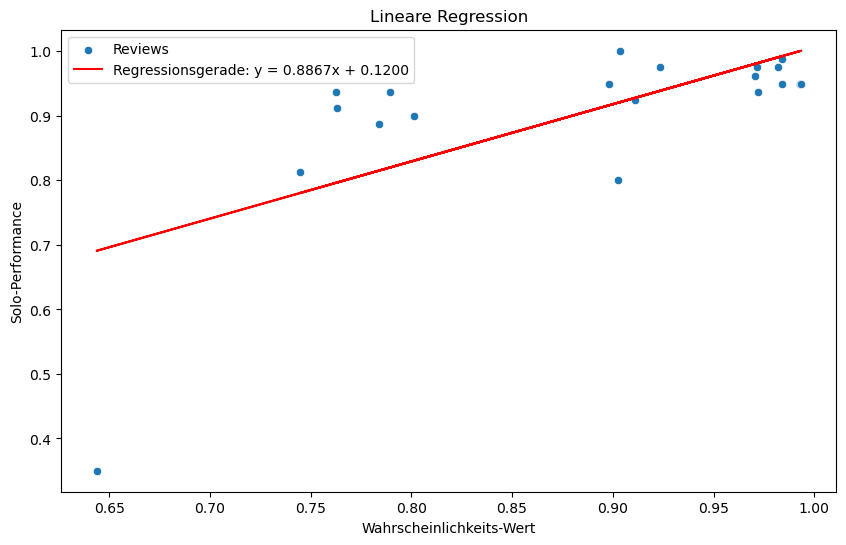

t-Wert: 3.8033
p-Wert: 0.0013
r2-Wert: 0.4456


In [133]:
x_data = df_reviews['probability_value'].values.reshape(-1, 1)
y_data = df_reviews['participants_solo_correct'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(x_data, y_data)
y_pred = linear_regressor.predict(x_data)
slope = linear_regressor.coef_[0][0]
intercept = linear_regressor.intercept_[0]
r2_value = r2_score(y_data, y_pred)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='probability_value', y='participants_solo_correct', data=df_reviews, label='Reviews')
plt.plot(x_data, y_pred, color='red', label=f'Regressionsgerade: y = {slope:.4f}x + {intercept:.4f}')
plt.xlabel('Wahrscheinlichkeits-Wert')
plt.ylabel('Solo-Performance')
plt.title('Lineare Regression')
plt.legend()
plt.savefig("figures/linreg_reviews_prob.png", dpi=1000)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(df_reviews['probability_value'], df_reviews['participants_solo_correct'])
t_statistic = slope / std_err

print(f"t-Wert: {t_statistic:.4f}")
print(f"p-Wert: {p_value:.4f}")
print(f"r2-Wert: {r2_value:.4f}")

Eine weitere lineare Regression wurde durchgeführt, um zu untersuchen, ob ein signifikanter Zusammenhang zwischen der Solo-Performance und der Häufigkeit, mit der der KI gefolgt wurde, besteht. Wie in Abbildung 7 zu erkennen, scheint es einen leichten Zusammenhang zu geben. Allerdings ist weder die Steigung der Regressionsfunktion noch der R2-Wert mit 0.1191 sonderlich hoch. Der T-Wert von 0.1362 (p-Wert: 0.1362) ergeben keinen signifikanten Zusammenhang der Solo-Performance und der Häufigkeit der Probanden der KI zu folgen.

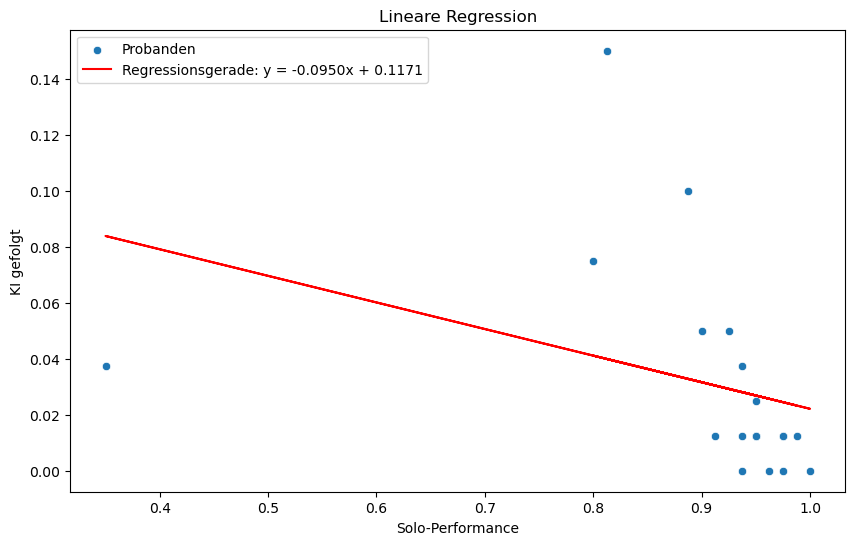

t-Wert: -1.5601
p-Wert: 0.1362
r2-Wert: 0.1191


In [134]:
x_data = df_reviews['participants_solo_correct'].values.reshape(-1, 1)
y_data = df_reviews['followed_ai'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(x_data, y_data)
y_pred = linear_regressor.predict(x_data)
slope = linear_regressor.coef_[0][0]
intercept = linear_regressor.intercept_[0]
r2_value = r2_score(y_data, y_pred)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='participants_solo_correct', y='followed_ai', data=df_reviews, label='Probanden')
plt.plot(x_data, y_pred, color='red', label=f'Regressionsgerade: y = {slope:.4f}x + {intercept:.4f}')
plt.xlabel('Solo-Performance')
plt.ylabel('KI gefolgt')
plt.title('Lineare Regression')
plt.legend()
plt.savefig("figures/linreg_reviews_follow.png", dpi=1000)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(df_reviews['participants_solo_correct'], df_reviews['followed_ai'])
t_statistic = slope / std_err

print(f"t-Wert: {t_statistic:.4f}")
print(f"p-Wert: {p_value:.4f}")
print(f"r2-Wert: {r2_value:.4f}")

Jedoch fällt bei Betrachtung der Abbildung 7 auf, dass es einen offensichtlichen Ausreißer gibt, der die Regressionsfunktion sehr verzerrt: Das Review mit der ID 3 weist eine Solo-Performance von lediglich 0.35 auf und liegt damit weit unter dem Rest der Reviews mit einem Mindestwert von 0.8 (siehe Tabelle 17). Aufgrund dieser Beobachtung wurde eine weitere lineare Regression durchgeführt, nachdem dieser Ausreißer (Review 3) herausgefiltert wurde. Diese zweite Regression zeigt ein anderes Bild. Sowohl die Steigung der Regressionsgeraden als auch der Korrelationskoeffizient (R2-Wert: 0.7076) sind im Vergleich zur ersten Regression deutlich erhöht. Der T-Wert von -6.4133 (p-Wert: 0.00) zeigen einen klaren signifikanten Effekt. Die Solo-Performance hat somit einen signifikanten Einfluss auf die Häufigkeit, mit der die Probanden der KI folgen.

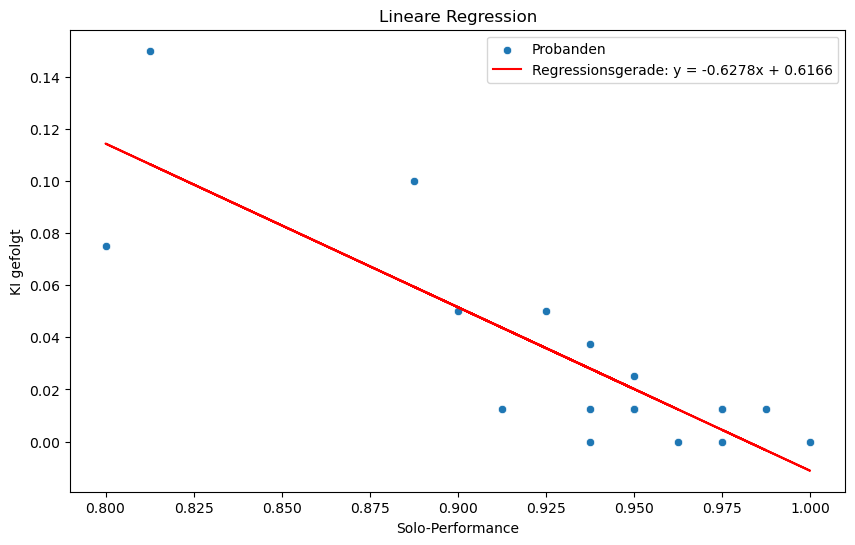

t-Wert: -6.4133
p-Wert: 0.0000
r2-Wert: 0.7076


In [135]:
df_reviews = df_reviews[df_reviews['participants_solo_correct'] > 0.4]
x_data = df_reviews['participants_solo_correct'].values.reshape(-1, 1)
y_data = df_reviews['followed_ai'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(x_data, y_data)
y_pred = linear_regressor.predict(x_data)
slope = linear_regressor.coef_[0][0]
intercept = linear_regressor.intercept_[0]
r2_value = r2_score(y_data, y_pred)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='participants_solo_correct', y='followed_ai', data=df_reviews, label='Probanden')
plt.plot(x_data, y_pred, color='red', label=f'Regressionsgerade: y = {slope:.4f}x + {intercept:.4f}')
plt.xlabel('Solo-Performance')
plt.ylabel('KI gefolgt')
plt.title('Lineare Regression')
plt.legend()
plt.savefig("figures/linreg_reviews_follow_cleaned.png", dpi=1000)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(df_reviews['participants_solo_correct'], df_reviews['followed_ai'])
t_statistic = slope / std_err

print(f"t-Wert: {t_statistic:.4f}")
print(f"p-Wert: {p_value:.4f}")
print(f"r2-Wert: {r2_value:.4f}")